In [1]:
ENV["LIBTENSORFLOW"]="/usr/local/cuda-8.0/targets/x86_64-linux/lib/libtensorflow"
# ENV["TF_USE_GPU"]="1"
# Pkg.build("TensorFlow")
using TensorFlow
using CSV: read
using Distributions: Normal
using ProgressMeter: @showprogress
using PyPlot: plot, axvline, axhline, xlim

In [2]:
type AE
    _in  ::Int64
    _int ::Int64
    _out ::Int64
    
    W1   ::Any
    W2   ::Any
    W1t  ::Any
    W2t  ::Any
    b1   ::Any
    b2   ::Any
    b3   ::Any
    b4   ::Any
    
    sess  ::Any
    loss  ::Any
    opt   ::Any
    code  ::Any
    dist  ::Any
    saver ::Any
    
end
AE() = AE(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)

AE

In [3]:
# Reading the data
f = CSV.read("./gyroscope.csv")

# definition of commonly used constants
T = Int64(floor(length(f[:,11]) / 3))   # number of data points per input channel
Nw = 3                                  # window size
Nc = 3                                  # number of inputs
Ncw = Nc * Nw                           # input size
TNw = Int64(floor(T/Nw))                # number of time stamps

2709

In [4]:
function data_init(ae)
    ae._in = Ncw
    ae._int = ae._in - 1
    ae._out = ae._int - 1

    s = Array{Float64, 2}(Ncw,TNw)
    for i=1:TNw
        s[:,i] .= vec(convert(Array,f[Nw*(i-1)+1:Nw*i,11:13]))
    end
    return s
end

function data_init(ae_in, ae_out)
    ae_out._in =  ae_in._out
    ae_out._int = ae_out._in - 1
    ae_out._out = ae_out._int - 1

    return run(ae_in.sess, ae_in.code)
end

data_init (generic function with 2 methods)

In [5]:
function weight_variable(shape, λ=0.1, reg=nn.l2_loss)
    W = Variable(map(Float64, rand(Normal(0, .01), shape...)))
    # regularization term
    wd = λ * reg(W)
    TensorFlow.add_to_collection(:regularizers, wd)
    return W
end

function bias_variable(shape)
    b = Variable(fill(Float64(.1), shape...))
    return b
end

# returns a tensor that computes the autoencoder output for a timestamp t of the input array s
function autoencoder(ae, input)
    enc = nn.sigmoid(ae.W2 * nn.sigmoid(ae.W1 * input + ae.b1) + ae.b2)
    TensorFlow.add_to_collection(:encoders, enc)
    return nn.sigmoid(ae.W1t * nn.sigmoid(ae.W2t * enc + ae.b3) + ae.b4)
end

autoencoder (generic function with 1 method)

In [6]:
function var_init(ae)
    ae.sess = Session(Graph())

    @tf begin
        x = placeholder(Float64, shape=[ae._in, 1])

        ae.W1 = weight_variable([ae._int, ae._in])
        ae.b1 = bias_variable([ae._int, 1])

        ae.W2 = weight_variable([ae._out, ae._int])
        ae.b2 = bias_variable([ae._out, 1])

        # this is a tied weight
        ae.W2t = transpose(ae.W2)
        ae.b3 = bias_variable([ae._int, 1])

        # this is a tied weight too
        ae.W1t = transpose(ae.W1)
        ae.b4 = bias_variable([ae._in, 1])
    end
end

var_init (generic function with 1 method)

In [7]:
function build_net(ae, _data)
    # initialize input as a matrix; passing vectors does not work
    input = Array{Any, 2}(ae._in,1)

    @tf begin
        data = constant(_data)

        # iterate over all time windows
        @showprogress for t=1:TNw
            # input is the t-th column of the data
            input = slice(data,[1,t],[ae._in,1])
            TensorFlow.add_to_collection(:losses, reduce_mean((autoencoder(ae, input) - input)^2 ))
        end
        # add MSE and regularization loss for total loss
        ae.loss = reduce_sum(stack(get_collection(:losses))) + reduce_sum(stack(get_collection(:regularizers)))  


        # iterate over all pairs of adjacent time windows; calling get_collection before a collection has been
        # populated does not give a reference to the Array that will be populated by add_to_collection
        ae.code = get_collection(:encoders)
        @showprogress for t=2:TNw
            TensorFlow.add_to_collection(:dists, nn.l2_loss(ae.code[t]-ae.code[t-1])/sqrt(multiply(nn.l2_loss(ae.code[t]),nn.l2_loss(ae.code[t-1]))))
        end  
        # concatenate encoder outputs to build the code
        ae.dist = stack(get_collection(:dists))'

        ae.opt = train.minimize(train.AdamOptimizer(1e-4), ae.loss)
        
        ae.saver = train.Saver()
    end
end

build_net (generic function with 1 method)

In [8]:
# train new network
function _train(ae; emax=1e3, rstr=false, trn=true, save_path="./checkpoints/", save_folder=nothing, restore_path=nothing)
    run(ae.sess, global_variables_initializer())
    # restore
    if rstr train.restore(ae.saver, ae.sess, restore_path) end

    # train
    if trn
        mkdir(joinpath(save_path, save_folder))
        tic()
        for epoch=1:emax
            cur_loss, _ = run(ae.sess, (ae.loss, ae.opt))
            if epoch%(emax/10) == 0 || epoch == 1
                elapsed = toq(); tic()
                info("epoch: $(@sprintf("%5i", epoch)) | elapsed time: $(@sprintf("%6.1f", elapsed)) seconds | loss: $(@sprintf("%9.4f", cur_loss)) | accuracy: ...")
                train.save(ae.saver, ae.sess, joinpath(save_path, save_folder, "train_e$epoch"))
            end
        end
    end
end

_train (generic function with 1 method)

In [9]:
ae1 = AE()
data = data_init(ae1)
var_init(ae1)
build_net(ae1, data)
_train(ae1, rstr=true, trn=false, restore_path="/home/ringo/Desktop/Autoencoder/checkpoints/ae_layer1/train_e1000.0")

2018-07-18 01:02:22.960481: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2018-07-18 01:02:23.046910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:897] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-07-18 01:02:23.047249: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1404] Found device 0 with properties: 
name: GeForce GTX 1080 major: 6 minor: 1 memoryClockRate(GHz): 1.86
pciBusID: 0000:01:00.0
totalMemory: 7.92GiB freeMemory: 7.48GiB
2018-07-18 01:02:23.047258: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1483] Adding visible gpu devices: 0
2018-07-18 01:02:23.216836: I tensorflow/core/common_runtime/gpu/gpu_device.cc:964] Device interconnect StreamExecutor with strength 1 edge matrix:
2018-07-18 01:02:23.216855: I tensorflow/core/common_runtime/gpu/gpu_device

In [15]:
ae2 = AE()
data = data_init(ae1, ae2)
var_init(ae2)
build_net(ae2, data)
_train(ae2, save_folder="ae_layer2")

2018-07-18 01:09:14.293474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1483] Adding visible gpu devices: 0
2018-07-18 01:09:14.293503: I tensorflow/core/common_runtime/gpu/gpu_device.cc:964] Device interconnect StreamExecutor with strength 1 edge matrix:
2018-07-18 01:09:14.293506: I tensorflow/core/common_runtime/gpu/gpu_device.cc:970]      0 
2018-07-18 01:09:14.293509: I tensorflow/core/common_runtime/gpu/gpu_device.cc:983] 0:   N 
2018-07-18 01:09:14.293585: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 7222 MB memory) -> physical GPU (device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1)


LoadError: [91mKeyError: key Array{Float64,2} not found[39m

In [11]:
ae3 = AE()
data = data_init(ae2, ae3)
var_init(ae3)
build_net(ae3, data)
_train(ae3, save_folder="ae_layer3")

2018-07-18 01:06:59.287389: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1483] Adding visible gpu devices: 0
2018-07-18 01:06:59.287417: I tensorflow/core/common_runtime/gpu/gpu_device.cc:964] Device interconnect StreamExecutor with strength 1 edge matrix:
2018-07-18 01:06:59.287421: I tensorflow/core/common_runtime/gpu/gpu_device.cc:970]      0 
2018-07-18 01:06:59.287424: I tensorflow/core/common_runtime/gpu/gpu_device.cc:983] 0:   N 
2018-07-18 01:06:59.287502: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 7222 MB memory) -> physical GPU (device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1)


LoadError: [91mTensorflow error: Status: Shape must be rank 2 but is rank 0 for 'Slice/Slice_2' (op: 'Slice') with input shapes: [], [2], [2].
[39m

In [12]:
# graph the distances of the adjacent time stamps
x = linspace(1,TNw-1,TNw-1); y = run(ae3.sess, ae3.dist)
thresh = 0.2
max_value = maximum(y)
axhline(y=thresh*max_value, color="orange", linewidth=0.5)
plot(x,y, color="red", linewidth=0.5, linestyle="--")
xlim(800,1500)

LoadError: [91mPyError (ccall(@pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, arg, kw)) <class 'ValueError'>
ValueError('x and y must have same first dimension, but have shapes (2708,) and (1,)',)
  File "/home/ringo/Programs/anaconda3/envs/envAE/lib/python3.5/site-packages/matplotlib/pyplot.py", line 3358, in plot
    ret = ax.plot(*args, **kwargs)
  File "/home/ringo/Programs/anaconda3/envs/envAE/lib/python3.5/site-packages/matplotlib/__init__.py", line 1855, in inner
    return func(ax, *args, **kwargs)
  File "/home/ringo/Programs/anaconda3/envs/envAE/lib/python3.5/site-packages/matplotlib/axes/_axes.py", line 1527, in plot
    for line in self._get_lines(*args, **kwargs):
  File "/home/ringo/Programs/anaconda3/envs/envAE/lib/python3.5/site-packages/matplotlib/axes/_base.py", line 406, in _grab_next_args
    for seg in self._plot_args(this, kwargs):
  File "/home/ringo/Programs/anaconda3/envs/envAE/lib/python3.5/site-packages/matplotlib/axes/_base.py", line 383, in _plot_args
    x, y = self._xy_from_xy(x, y)
  File "/home/ringo/Programs/anaconda3/envs/envAE/lib/python3.5/site-packages/matplotlib/axes/_base.py", line 242, in _xy_from_xy
    "have shapes {} and {}".format(x.shape, y.shape))
[39m

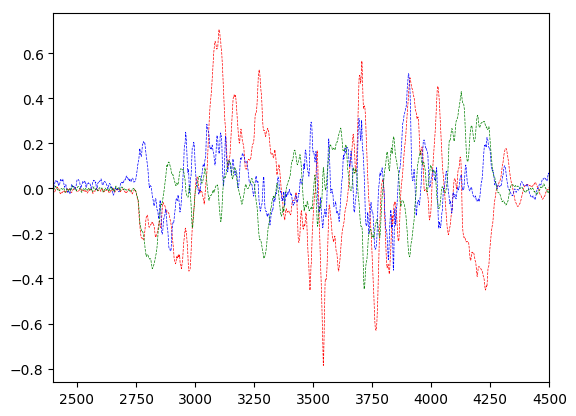

(2400, 4500)

In [13]:
# view detected breakpoints against input data
enum_dist = Iterators.filter(x->x[2]>thresh*max_value,enumerate(y))
for val in enum_dist axvline(x=Nw*val[1], color="orange", linewidth=0.5) end

T = Int64(floor(T))
x = linspace(1,T,T)
y1 = f[1:T,11]
y2 = f[1:T,12]
y3 = f[1:T,13]
plot(x,y1, color="red", linewidth=0.5, linestyle="--")
plot(x,y2, color="blue", linewidth=0.5, linestyle="--")
plot(x,y3, color="green", linewidth=0.5, linestyle="--")
xlim(2400,4500)